<a href="https://colab.research.google.com/github/momenashra/Algorithms/blob/main/Time_series_analysis_using_LSTM_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/CYSHIELD_TASK.csv")  # Replace with the actual file name


In [5]:
df.head()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city
0,33,16.0,20.0,2021-10-29T03:33:52Z,16.0,product y,Bahary,North
1,30,16.0,20.0,2021-10-23T12:29:27Z,16.0,product y,Dar El-Salam,Cairo
2,2,45.0,30.0,2021-08-03T09:14:16Z,45.0,product z,Miamy,North
3,3,16.0,3.0,2021-08-17T09:00:50Z,16.0,product y,Miamy,North
4,1,45.0,27.0,2021-09-06T19:57:02Z,45.0,product z,Miamy,North


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
# Sort the DataFrame by 'Date'
df = df.sort_values(by='date')
# Set 'Date' as the index
df.set_index('date', inplace=True)

In [7]:
df.head()

,quantity,UnitePrice,discount,retail price,product_name,area,city
date,,,,,,,
2021-03-31,5,102.0,33.0,102.0,product x,El-Mokattam,Cairo
2021-04-30,1,16.0,9.0,16.0,product y,Ain Shams,Cairo
2021-05-08,10,16.0,9.0,16.0,product y,El-Zaitoun,Cairo
2021-05-08,10,45.0,22.0,45.0,product z,El-Zaitoun,Cairo
2021-05-22,10,16.0,20.0,16.0,product y,Bakos,North


In [8]:
df['total price'] = df['UnitePrice'] * df['quantity']

In [9]:
df.describe()

,quantity,UnitePrice,discount,retail price,total price
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,7.705509,60.555426,25.917225,59.615776,299.344324
std,100.466019,35.270286,14.124298,36.944778,1735.799950
min,1.000000,10.000000,-1.000000,0.000000,16.000000
25%,2.000000,16.000000,20.000000,16.000000,80.000000
50%,3.000000,45.000000,31.000000,45.000000,135.000000
75%,5.000000,99.000000,33.000000,99.000000,269.250000
max,5000.000000,102.000000,561.000000,102.000000,80000.000000



*   obviously there is outilers in data since max is far from
3rd quantile in quantity and discount .
*   if discount here is percentage we must impute any row with discount > 100 .



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2995 entries, 2021-03-31 to 2023-01-17
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   retail price  2995 non-null   float64
 4   product_name  2995 non-null   object 
 5   area          2970 non-null   object 
 6   city          2995 non-null   object 
 7   total price   2995 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 210.6+ KB


In [11]:
df.isnull().sum()  # Shows the count of missing values per column

,0
quantity,0
UnitePrice,0
discount,0
retail price,0
product_name,0
area,25
city,0
total price,0


In [12]:
area_frequency = df['area'].value_counts()
area_frequency
#not icluding nan

,count
area,
El-Agamy,301
El-Seyouf,300
Nasr City,272
Sidy Bishr,158
El-Sheikh Zayed,151
...,...
Helwan,1
Al Sulaimaniyah,1
Marsa Matrouh,1


Get realation between two categorical features .

In [13]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['area'], df['city'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
p

0.0

In [14]:
df.drop(columns=['area'], inplace=True)

area is not importatnt feature since it doesn't effect our forecasting for each city and highly correlated with city feature (p=0) .

In [15]:
# Example: Calculate the correlation between two specific features
feature_1 = 'UnitePrice'  # Replace with your first column name
feature_2 = 'retail price'  # Replace with your second column name

correlation = df[feature_1].corr(df[feature_2])

# Display the correlation
print(f"Correlation between {feature_1} and {feature_2}: {correlation:.2f}")

Correlation between UnitePrice and retail price: 0.93


result suggests multicollinearity .

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
max_lag = 5
gc_result = grangercausalitytests(df[[feature_1, feature_2]], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6794  , p=0.4099  , df_denom=2991, df_num=1
ssr based chi2 test:   chi2=0.6801  , p=0.4096  , df=1
likelihood ratio test: chi2=0.6800  , p=0.4096  , df=1
parameter F test:         F=0.6794  , p=0.4099  , df_denom=2991, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9429  , p=0.0195  , df_denom=2988, df_num=2
ssr based chi2 test:   chi2=7.8989  , p=0.0193  , df=2
likelihood ratio test: chi2=7.8885  , p=0.0194  , df=2
parameter F test:         F=3.9429  , p=0.0195  , df_denom=2988, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8437  , p=0.0364  , df_denom=2985, df_num=3
ssr based chi2 test:   chi2=8.5510  , p=0.0359  , df=3
likelihood ratio test: chi2=8.5388  , p=0.0361  , df=3
parameter F test:         F=2.8437  , p=0.0364  , df_denom=2985, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6327  , p=0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


causality test must be performed in stationary data although is has strong causlaity so we can say that UnitePrice can help predict retail price espacially with dynamic models like SARIMAX so i will keep both features .

In [17]:
columns_to_check = ['quantity', 'UnitePrice', 'discount', 'retail price']
df_filtered = df.copy()  # Copy the original DataFrame to keep it intact
def detect_outliers_iqr(column, tolerance=18):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - tolerance * IQR
    upper_bound = Q3 + tolerance * IQR
    return column[(column < lower_bound) | (column > upper_bound)]
outliers_dict = {}
# here i replaced standard 1.5 with bigger tolarance to preserve sufficient amout of data
# with 1.5 as the tolerance value our data was only around 750 rows and with 18 around 2250 .
for col in columns_to_check :
    outliers = detect_outliers_iqr(df[col])
    outliers_dict[col] = outliers.tolist()
    df_filtered = df_filtered[~df_filtered.index.isin(outliers.index)]



In [18]:
outliers_dict

{'quantity': [100,
  1000,
  5000,
  2000,
  100,
  200,
  232,
  100,
  200,
  60,
  100,
  100,
  100,
  100,
  100,
  60],
 'UnitePrice': [],
 'discount': [561.0],
 'retail price': []}

In [19]:
columns_to_check= ['UnitePrice','retail price','discount']
# Collect indices of rows to be dropped
rows_to_drop = []

# Iterate over each row using index and row content
for index, row in df_filtered[columns_to_check].iterrows():
    # Check if any value in the row is less than or equal to 0
     if (row[['UnitePrice', 'retail price']] <= 0).any() or row['discount'] < 0:
        # Add the index to the list of rows to be dropped
        rows_to_drop.append(index)

# Drop all collected rows at once
df_filtered.drop(index=rows_to_drop, inplace=True)

In [20]:
df_filtered.describe()

,quantity,UnitePrice,discount,retail price,total price
count,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000
mean,4.509778,60.418333,25.468387,61.328778,232.206667
std,6.161322,35.105540,10.454228,36.138879,347.318350
min,1.000000,10.000000,0.000000,11.000000,16.000000
25%,2.000000,16.000000,20.000000,16.000000,80.000000
50%,3.000000,45.000000,31.000000,45.000000,135.000000
75%,5.000000,99.000000,33.000000,99.000000,269.250000
max,50.000000,102.000000,100.000000,102.000000,4487.500000


In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2250 entries, 2021-03-31 to 2023-01-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2250 non-null   int64  
 1   UnitePrice    2250 non-null   float64
 2   discount      2250 non-null   float64
 3   retail price  2250 non-null   float64
 4   product_name  2250 non-null   object 
 5   city          2250 non-null   object 
 6   total price   2250 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 140.6+ KB


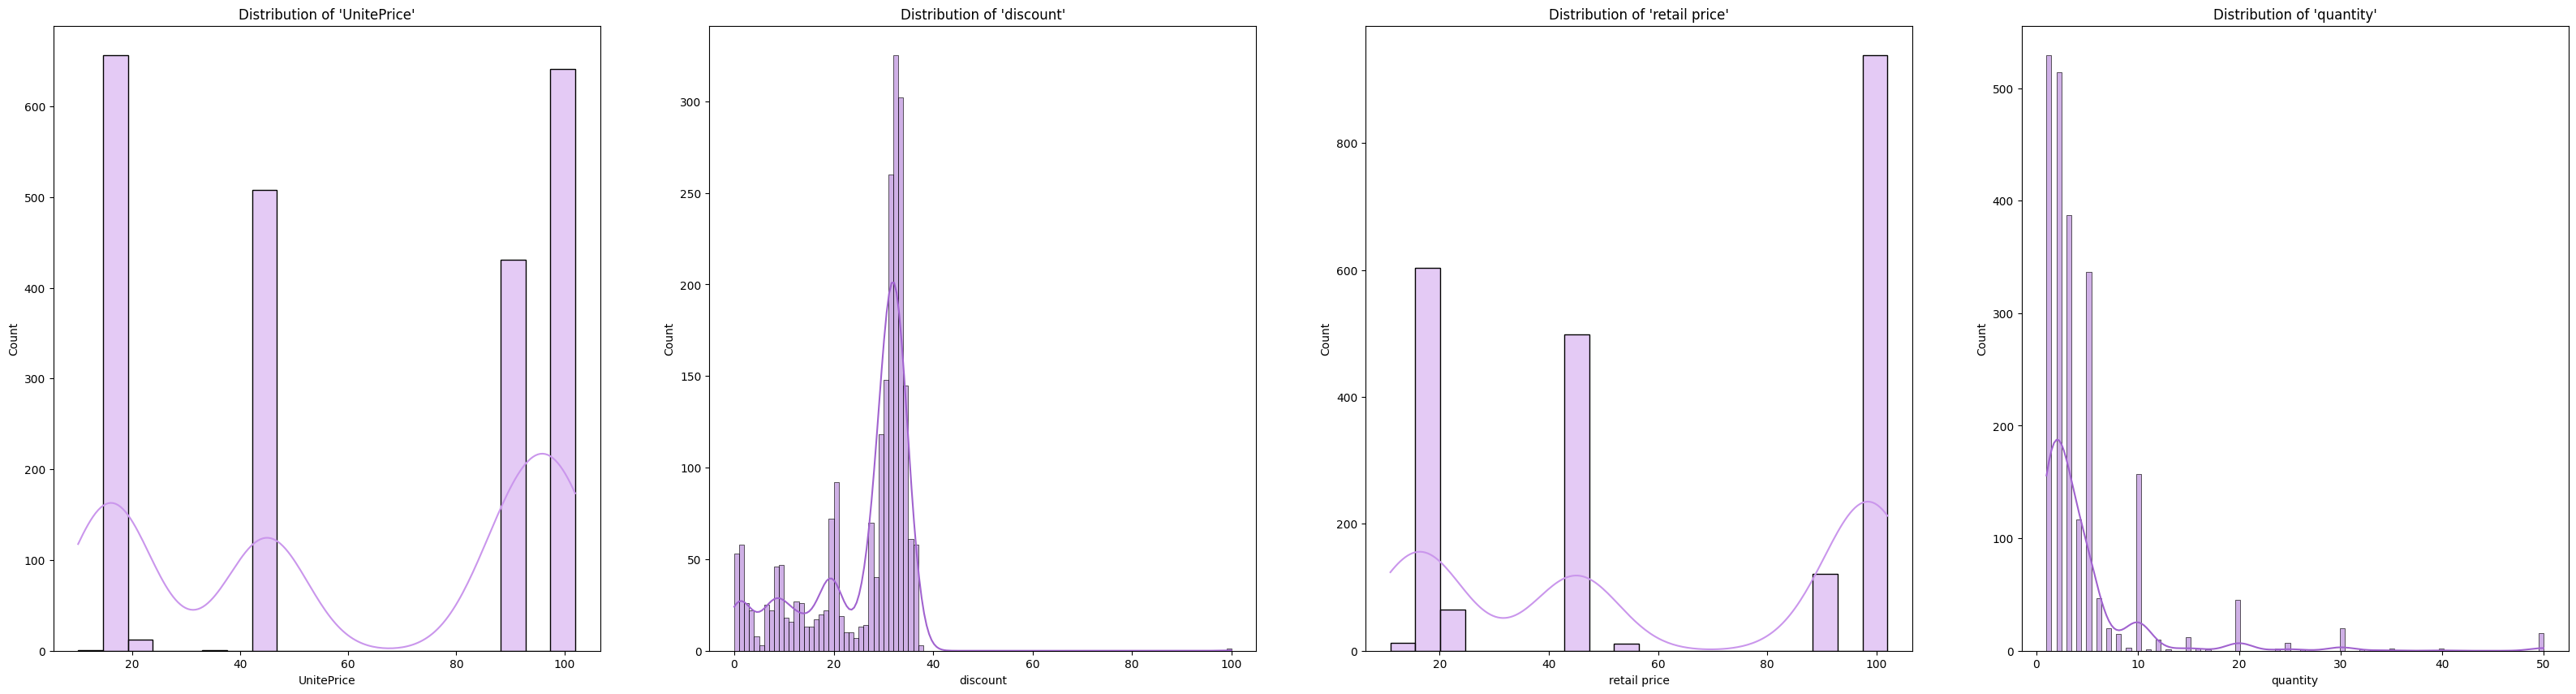

In [22]:
fig, axes = plt.subplots(1, 4, figsize = (40, 10))

sns.histplot(ax = axes[0], x = df_filtered["UnitePrice"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'UnitePrice'");

sns.histplot(ax = axes[1], x = df_filtered["discount"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'discount'");
sns.histplot(ax = axes[2], x = df_filtered["retail price"],
             bins = 20,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'retail price'");

sns.histplot(ax = axes[3], x = df_filtered["quantity"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'quantity'");


non of the columns looks normally distrbuted . this suggests norlmaization at data scaling part .



<Axes: xlabel='date', ylabel='quantity'>

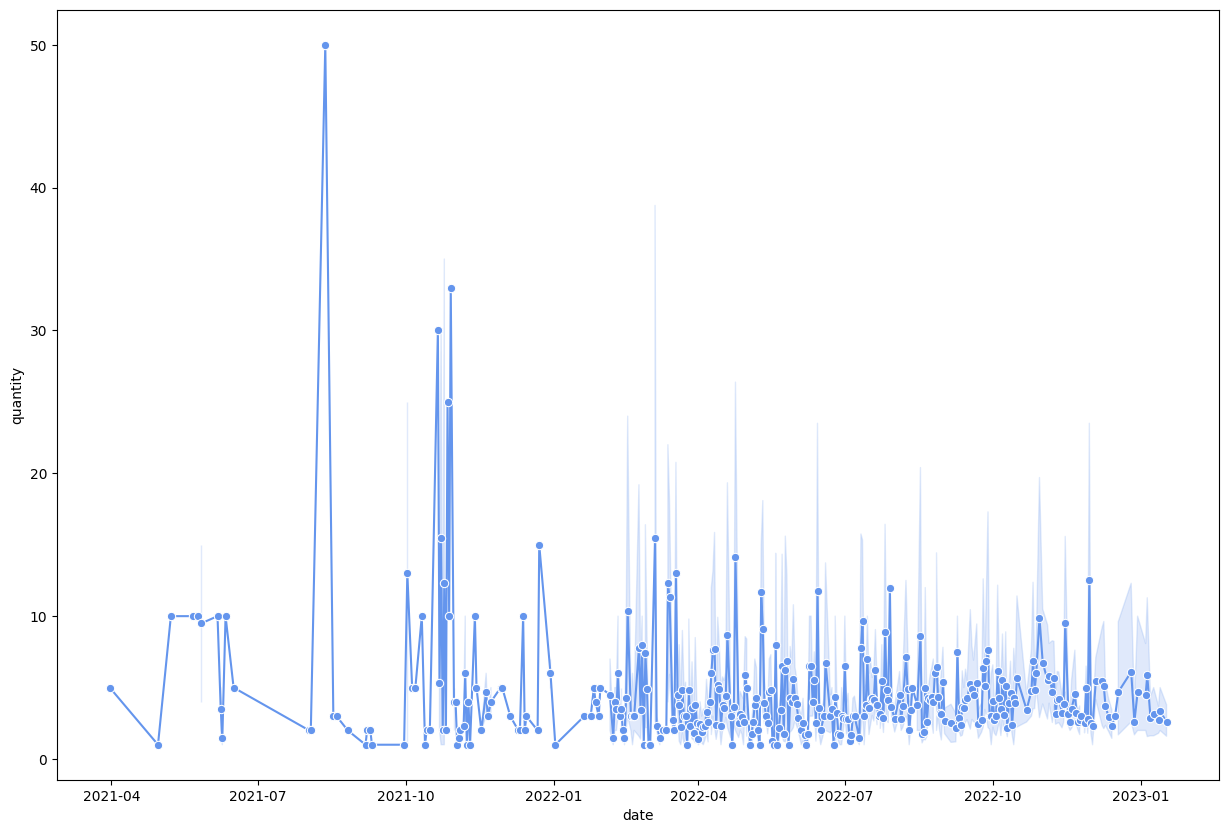

In [23]:
### Visualize time series ###
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
sns.lineplot(x=df_filtered.index, y=df_filtered["quantity"], color='cornflowerblue', marker='o')


In [24]:
# Create a pivot table to see data more clearly and make some relation with categorical data
pivot_df = df_filtered.pivot_table(
    index='date',
    columns=['product_name','city'],
    values=['quantity', 'UnitePrice', 'discount', 'retail price','total price'],
    aggfunc='sum',
    fill_value=0
)

# Flatten the multi-level columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index to turn 'Date' back into a column if needed
pivot_df.reset_index(inplace=True)


In [25]:
pivot_df

,date,UnitePrice_product x _Cairo,UnitePrice_product x _Giza,UnitePrice_product x _North,UnitePrice_product y_Cairo,UnitePrice_product y_Giza,UnitePrice_product y_North,UnitePrice_product z_Cairo,UnitePrice_product z_Giza,UnitePrice_product z_North,...,retail price_product z_North,total price_product x _Cairo,total price_product x _Giza,total price_product x _North,total price_product y_Cairo,total price_product y_Giza,total price_product y_North,total price_product z_Cairo,total price_product z_Giza,total price_product z_North
0,2021-03-31,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,510.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-30,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2,2021-05-08,0.0,0.0,0.0,16.0,0.0,0.0,45.0,0.0,0.0,...,0.0,0.0,0.0,0.0,160.0,0.0,0.0,450.0,0.0,0.0
3,2021-05-22,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,0.0,0.0
4,2021-05-25,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2023-01-07,99.0,297.0,693.0,0.0,32.0,0.0,0.0,0.0,135.0,...,135.0,99.0,891.0,1089.0,0.0,320.0,0.0,0.0,0.0,225.0
337,2023-01-09,297.0,396.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0.0,1485.0,396.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0
338,2023-01-12,0.0,99.0,396.0,16.0,0.0,16.0,45.0,0.0,90.0,...,90.0,0.0,99.0,891.0,80.0,0.0,32.0,135.0,0.0,315.0
339,2023-01-13,0.0,99.0,198.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,495.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0


so sparse data will make model lazy to learn .

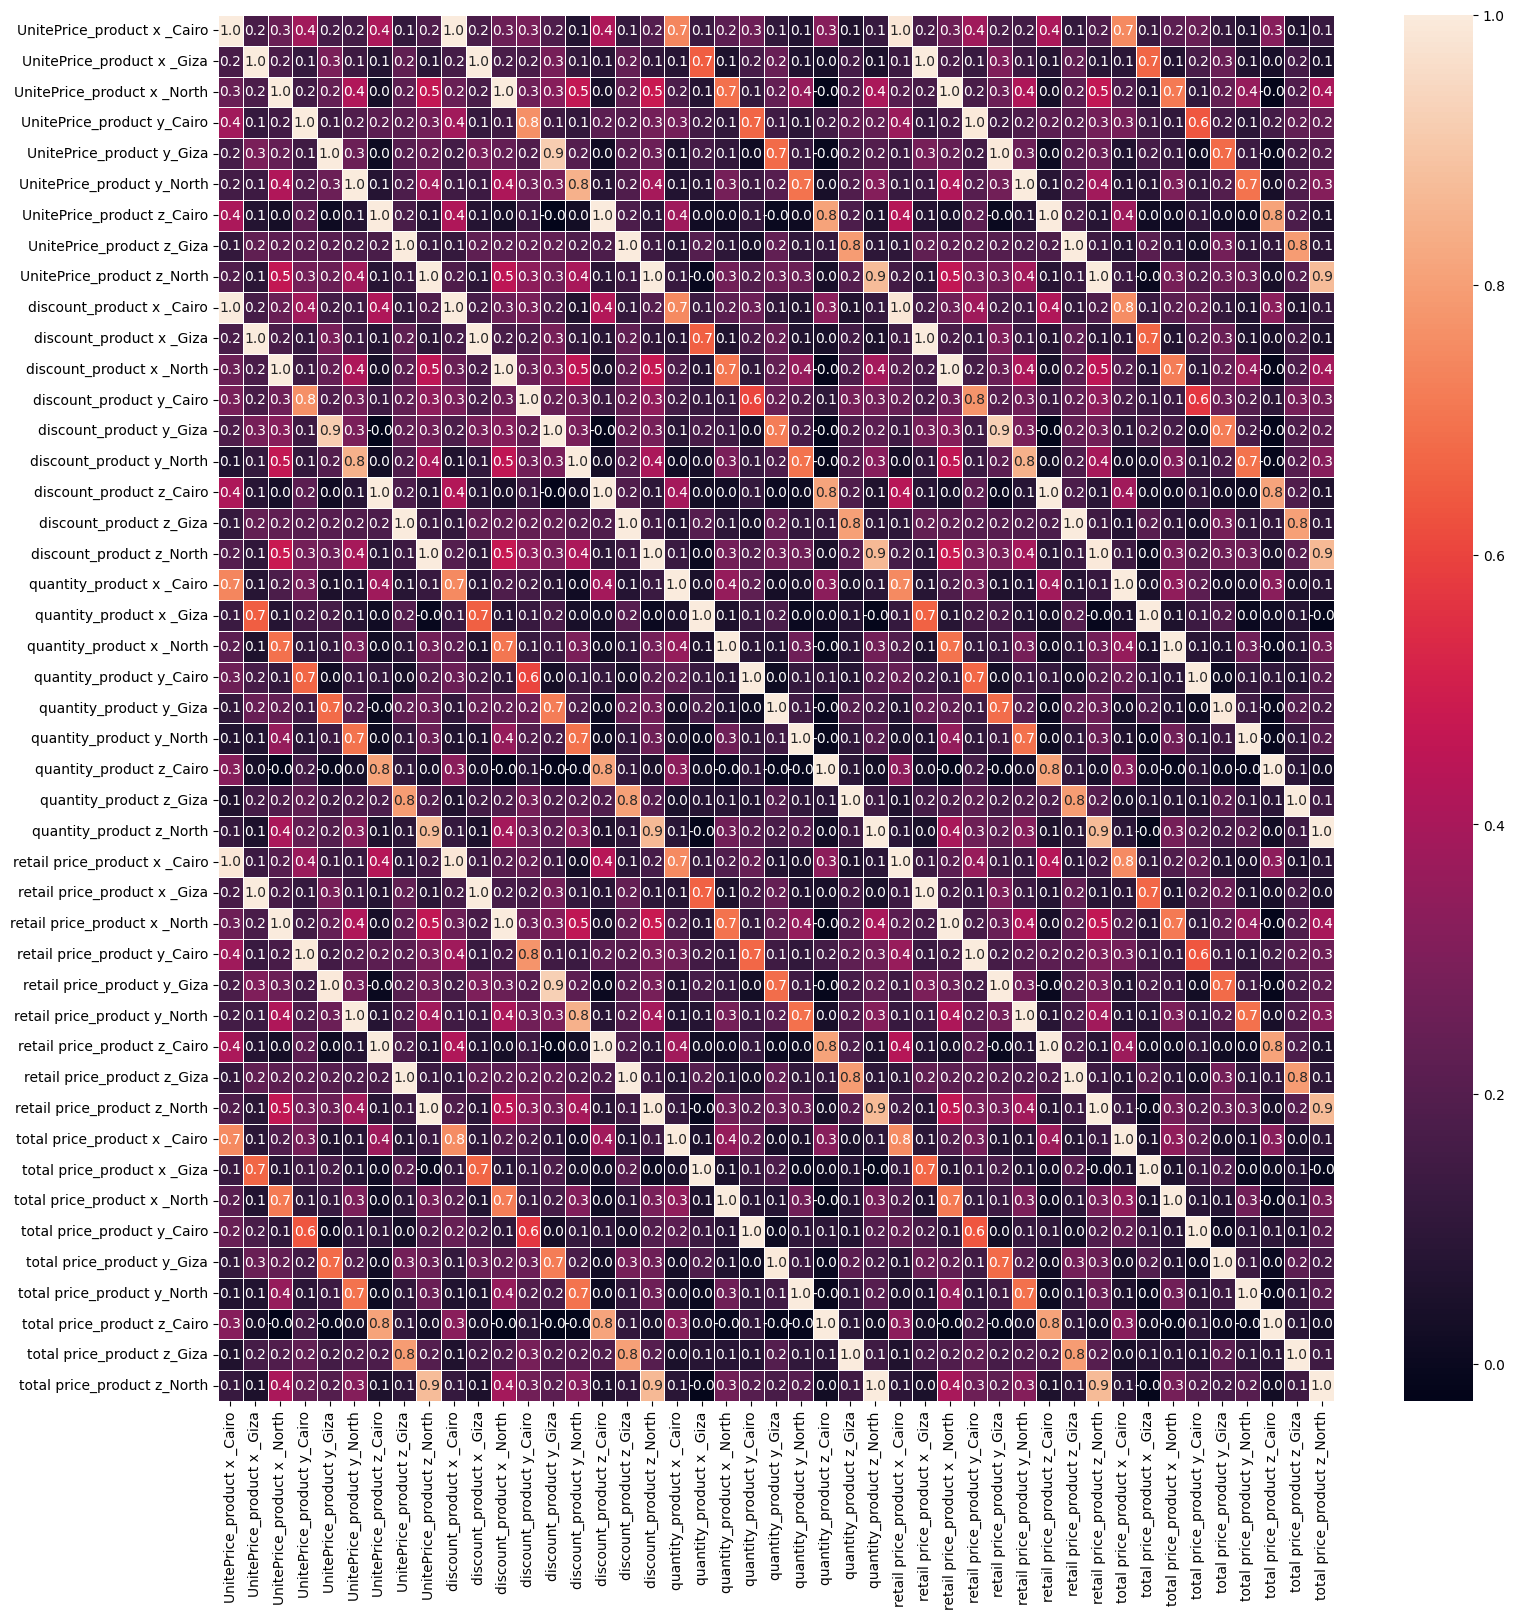

In [26]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pivot_df.drop(columns=['date']).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

*no significant correlations out of diagonal except for (retail , unit prices).*



In [27]:
# Select specific columns from pivot DataFrame
out_cols=['quantity_product x _Cairo', 'quantity_product x _Giza',
       'quantity_product x _North', 'quantity_product y_Cairo',
       'quantity_product y_Giza', 'quantity_product y_North',
       'quantity_product z_Cairo', 'quantity_product z_Giza',
       'quantity_product z_North']

In [28]:
pivot_df.iloc[:, 1:] = pivot_df.iloc[:, 1:].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
pivot_df.index

RangeIndex(start=0, stop=341, step=1)

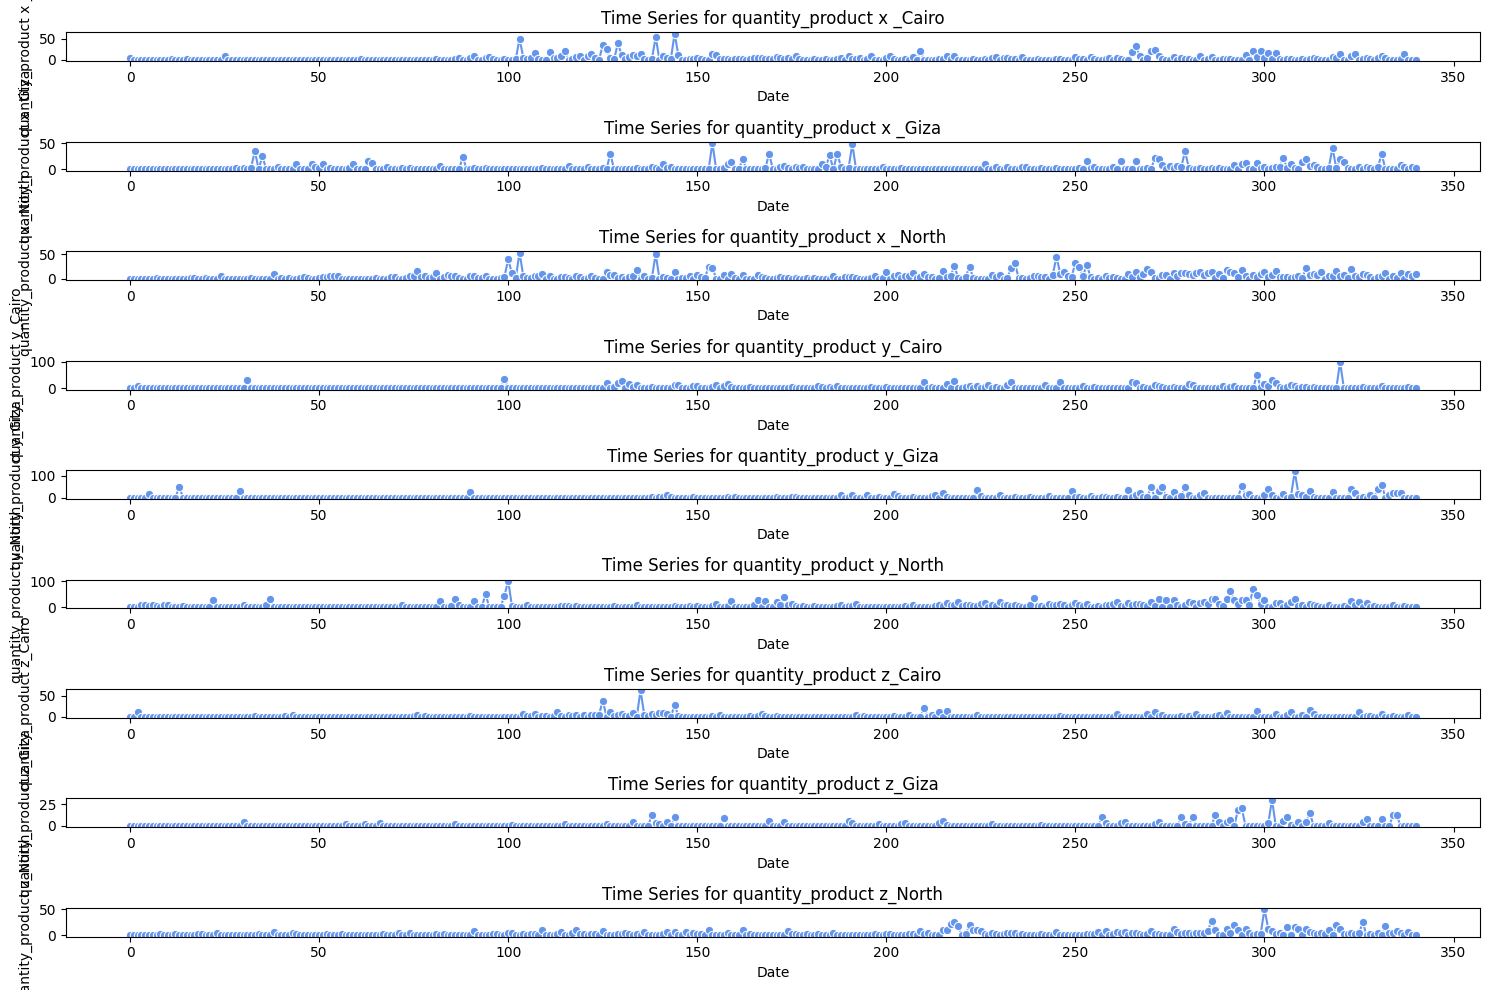

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with as many subplots as the number of out_cols
fig, ax = plt.subplots(nrows=len(out_cols), ncols=1, figsize=(15, 10))
# Loop over your target columns (out_cols) and create one plot for each
for i in range(len(out_cols)):
    sns.lineplot(x=pivot_df.index, y=pivot_df[out_cols[i]], ax=ax[i], color='cornflowerblue', marker='o')
    ax[i].set_title(f"Time Series for {out_cols[i]}")
    ax[i].set_xlabel('Date')
    # ax[i].set_ylabel(out_cols[i])

# Adjust layout to ensure plots are spaced properly
plt.tight_layout()

# Display the plot
plt.show()


In [806]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import RobustScaler


In [31]:
def test_stationarity(series):
    result = adfuller(series)
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Test for stationarity on each column (assuming each column is a time series)
for column in pivot_df[out_cols]:
    print(f"Testing stationarity for {column}")
    test_stationarity(pivot_df[column])


Testing stationarity for quantity_product x _Cairo
p-value: 3.3961131865764214e-05
Series is stationary
Testing stationarity for quantity_product x _Giza
p-value: 2.8209514690362886e-30
Series is stationary
Testing stationarity for quantity_product x _North
p-value: 6.722574439955189e-07
Series is stationary
Testing stationarity for quantity_product y_Cairo
p-value: 6.927286646921416e-30
Series is stationary
Testing stationarity for quantity_product y_Giza
p-value: 0.0007400980907808499
Series is stationary
Testing stationarity for quantity_product y_North
p-value: 0.0017741401237725452
Series is stationary
Testing stationarity for quantity_product z_Cairo
p-value: 0.09928252009830846
Series is not stationary
Testing stationarity for quantity_product z_Giza
p-value: 0.17884328559865548
Series is not stationary
Testing stationarity for quantity_product z_North
p-value: 0.0429388596072761
Series is stationary


i will try to resample data at certain times w

In [692]:
pivot_df_resampled=pivot_df.copy()
pivot_df_resampled['date'] = pd.to_datetime(pivot_df_resampled['date'])
pivot_df_resampled.set_index('date', inplace=True)

# Resample to weekly frequency (or any other suitable frequency)
pivot_df_resampled = pivot_df_resampled.resample('D').mean()

# Handle missing values by interpolation (if needed)
pivot_df_resampled.interpolate(method='linear', inplace=True)

In [693]:
pivot_df_resampled

,UnitePrice_product x _Cairo,UnitePrice_product x _Giza,UnitePrice_product x _North,UnitePrice_product y_Cairo,UnitePrice_product y_Giza,UnitePrice_product y_North,UnitePrice_product z_Cairo,UnitePrice_product z_Giza,UnitePrice_product z_North,discount_product x _Cairo,...,retail price_product z_North,total price_product x _Cairo,total price_product x _Giza,total price_product x _North,total price_product y_Cairo,total price_product y_Giza,total price_product y_North,total price_product z_Cairo,total price_product z_Giza,total price_product z_North
date,,,,,,,,,,,,,,,,,,,,,
2021-03-31,102.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,510.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
2021-04-01,98.6,0.0,0.0,0.533333,0.0,0.0,0.0,0.0,0.0,31.9,...,0.0,493.0,0.0,0.00,0.533333,0.0,0.0,0.0,0.0,0.0
2021-04-02,95.2,0.0,0.0,1.066667,0.0,0.0,0.0,0.0,0.0,30.8,...,0.0,476.0,0.0,0.00,1.066667,0.0,0.0,0.0,0.0,0.0
2021-04-03,91.8,0.0,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,29.7,...,0.0,459.0,0.0,0.00,1.600000,0.0,0.0,0.0,0.0,0.0
2021-04-04,88.4,0.0,0.0,2.133333,0.0,0.0,0.0,0.0,0.0,28.6,...,0.0,442.0,0.0,0.00,2.133333,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13,0.0,99.0,198.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,495.0,495.00,0.000000,0.0,0.0,0.0,0.0,0.0
2023-01-14,0.0,99.0,247.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,445.5,618.75,0.000000,0.0,0.0,0.0,0.0,0.0
2023-01-15,0.0,99.0,297.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,396.0,742.50,0.000000,0.0,0.0,0.0,0.0,0.0


-----------------------------------------------------------------------------------------------------------------------------

In [828]:
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import TimeDistributed,RepeatVector

In [829]:
y = pivot_df_resampled[out_cols]
X = pivot_df_resampled.drop(out_cols, axis=1)

In [830]:
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features (data leakage)
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [831]:
n_steps = 80
n_features_out=9
forecast_horizon = 10  # Predict 10 days ahead

In [832]:
X.shape

(658, 36)

In [833]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


In [834]:
dataset = hstack((X_scaled,y))

# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
n_output_features = y.shape[2]  # Number of output features (9)

In [835]:
import datetime

# Define your reference date (e.g., 2020-01-01)
reference_date = np.datetime64('2021-03-31')

# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column (which contains datetime.date)
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

# After converting, X will have numerical days values in place of the dates


In [836]:
X.shape

(569, 80, 36)

In [837]:
X = X.astype('float32')
y = y.astype('float32')

In [838]:
X_test= X[:10]
y_test= y[:10]

In [839]:
X_test.shape

(10, 80, 36)

In [840]:
X = X[10:]
y = y[10:]

In [841]:
X.shape

(559, 80, 36)

In [842]:
from sklearn.model_selection import train_test_split
# Assuming X and y are your input and output arrays respectively
test_size = 0.1  # 20% of the data for testing/'/'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (503, 80, 36), y_train shape: (503, 10, 9)
X_test shape: (10, 80, 36), y_test shape: (10, 10, 9)


In [843]:
print("X shape:", X.shape)  # Expected: (num_samples, n_steps, n_features)
print("y shape:", y.shape)  # Expected: (num_samples, 10)


X shape: (559, 80, 36)
y shape: (559, 10, 9)


In [851]:
# import tensorflow as tf

# def custom_loss(y_true, y_pred):
#     # Assign higher weight to non-zero sales (adjust weight as needed)
#     sample_weight = tf.where(y_true == 0, 5.0, 1.0)  # Weight=1 for zeros, 5 otherwise

#     # Calculate squared error
#     squared_error = tf.square(y_true - y_pred)

#     # Apply weights and compute mean
#     weighted_loss = tf.reduce_mean(sample_weight * squared_error)
#     return weighted_loss

In [871]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Input, Flatten

# Define input shape
input_shape = (n_steps, n_features)

# Input layer
inputs = Input(shape=input_shape)

# Bidirectional LSTM layer
bidirectional_lstm = Bidirectional(LSTM(50, return_sequences=True, activation='relu'))(inputs)

# Attention layer
attention_output = Attention()([bidirectional_lstm, bidirectional_lstm])

# Flattening the output
flat_output = Flatten()(attention_output)

# Batch normalization
batch_norm = BatchNormalization()(flat_output)

# Dropout layer
dropout = Dropout(0.15)(batch_norm)

# Output layer
outputs = Dense(n_output_features * forecast_horizon)(dropout)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Display the model summary
model.summary()


Model: "functional_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51            │ (None, 80, 36)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 80, 100)        │         34,800 │ input_layer_51[0][0]   │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_15 (Attention)  │ (None, 80, 100)        │              0 │ bidirectional_3[0][0], │
│                           │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 8000)           │              0 │ attention_15[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 8000)           │         32,000 │ flatten_10[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_42 (Dropout)      │ (None, 8000)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 90)             │        720,090 │ dropout_42[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 786,890 (3.00 MB)

 Trainable params: 770,890 (2.94 MB)

 Non-trainable params: 16,000 (62.50 KB)

In [872]:
# plot_model(model, show_shapes=True)

In [873]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/NLP/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [874]:
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=500,
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint],  # Add model_checkpoint here
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 3.6887
Epoch 1: val_loss improved from inf to 145.46170, saving model to /content/drive/MyDrive/NLP/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - loss: 3.6818 - val_loss: 145.4617
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3.5005
Epoch 2: val_loss improved from 145.46170 to 3.43852, saving model to /content/drive/MyDrive/NLP/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 3.4960 - val_loss: 3.4385
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 3.2985
Epoch 3: val_loss improved from 3.43852 to 3.31593, saving model to /content/drive/MyDrive/NLP/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 3.2966 - val_loss: 3.3159
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.3231
Epoch 4: val_loss did not improve from 3.31593
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 3.3197 - val_loss: 3.9091
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/

In [875]:
import os
print(os.listdir('/content/drive/MyDrive/NLP'))
best_model = load_model('/content/drive/MyDrive/NLP/best_model.keras')

['best_model.keras']


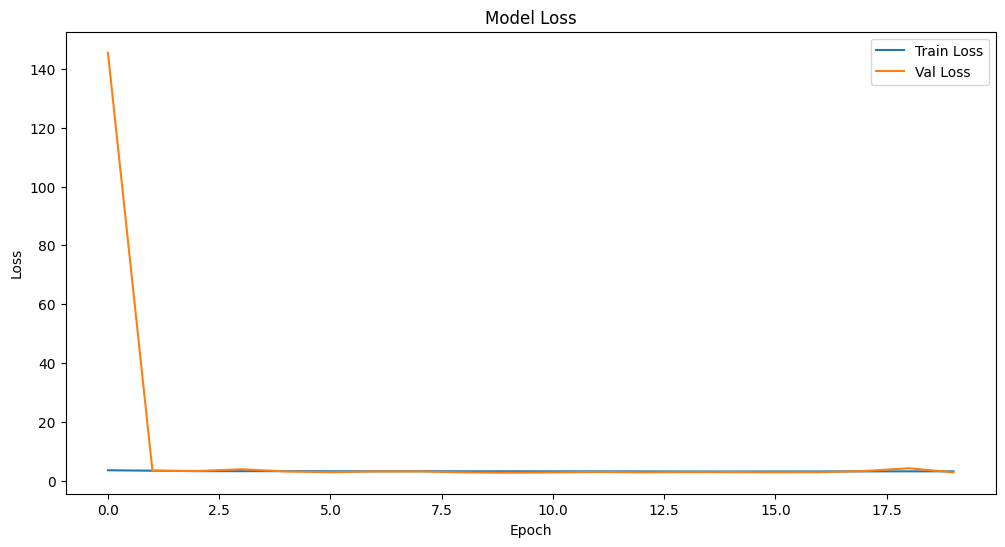

In [876]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [877]:
  # Making a prediction
y_pred = best_model.predict(X_test, verbose=0)  # Predict future sequences
y_pred = y_pred.reshape(y_pred.shape[0], forecast_horizon, n_output_features)
y_pred = y_pred.astype('int')
y_test = y_test.astype('int')

Combined shape: (10, 10, 18)
Mean Squared Error: 3.224444444444445
ROOt Mean Squared Error: 1.7956738134874175
Mean Absolute Error: 0.8466666666666668


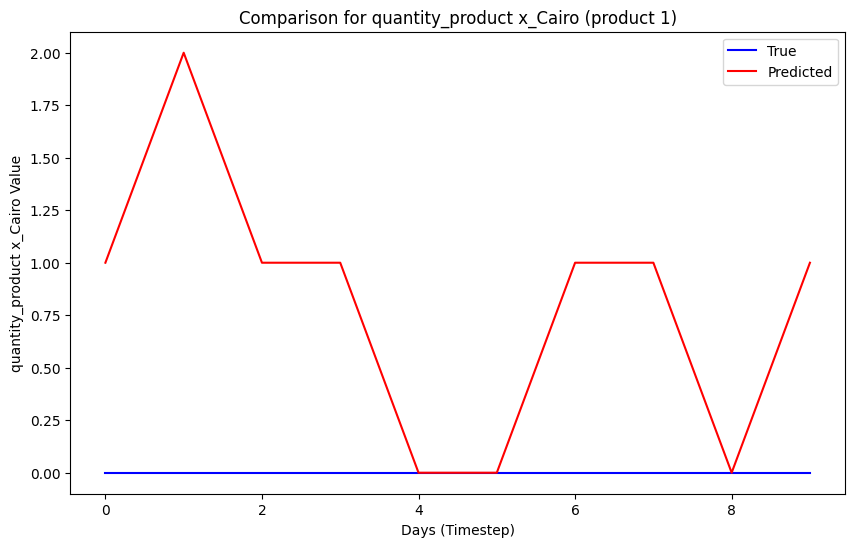

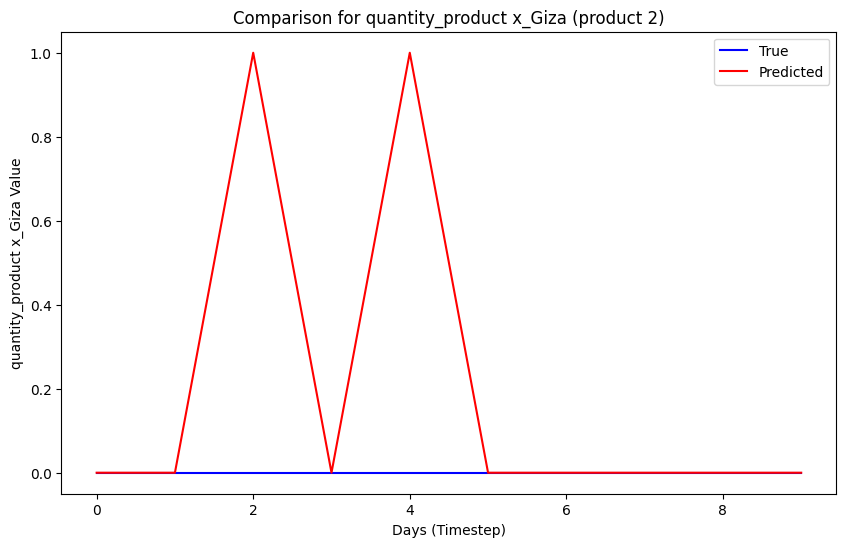

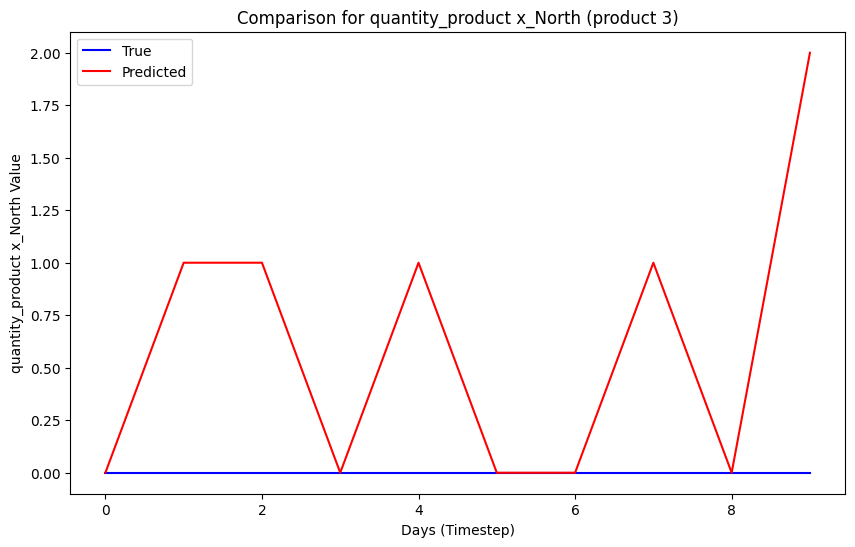

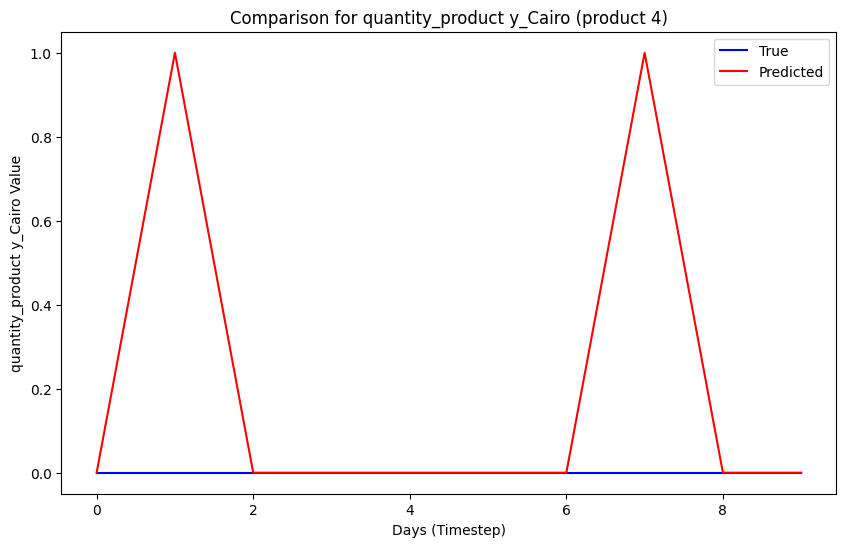

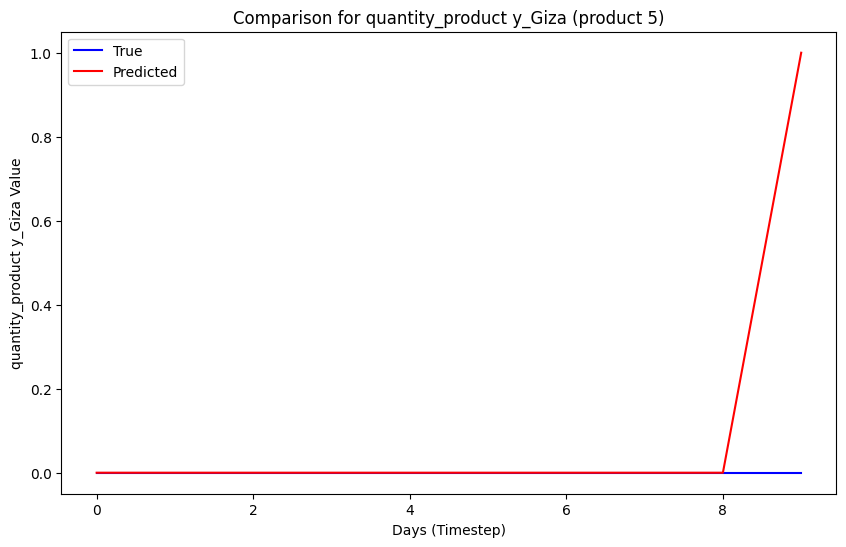

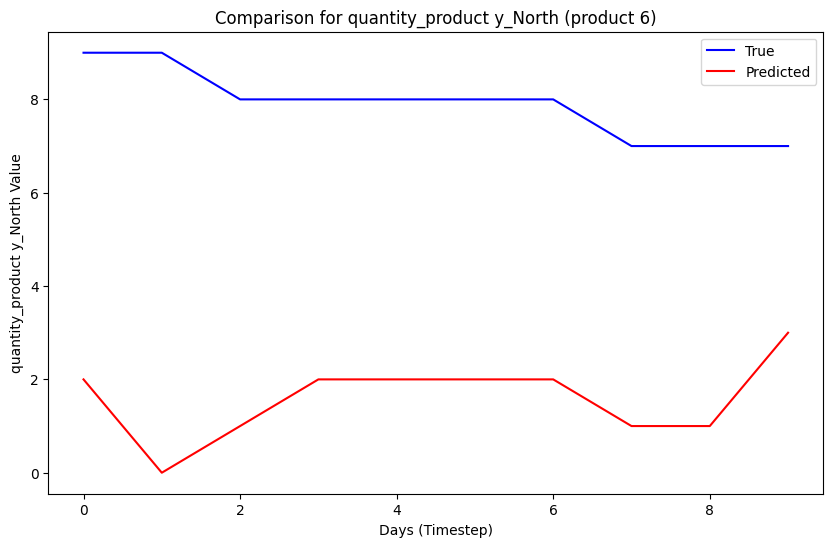

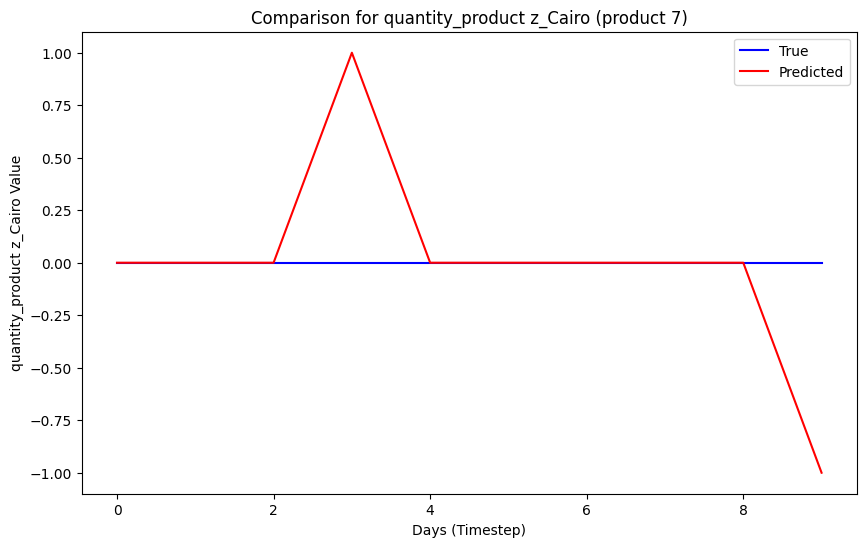

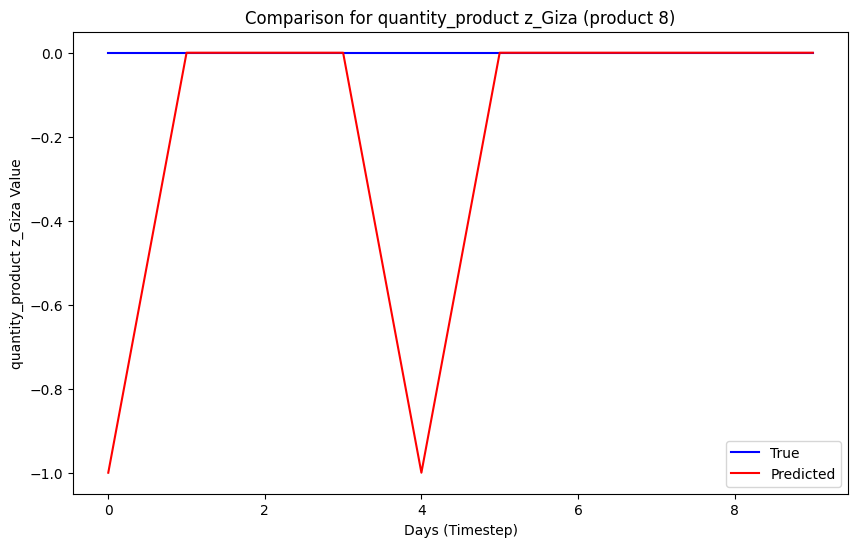

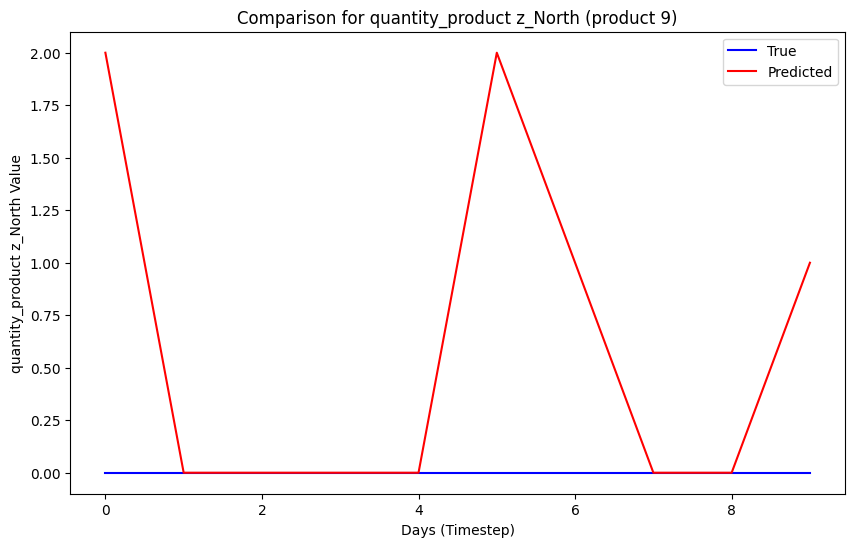

In [878]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'

]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute Mean Squared Error (MSE) for all samples, timesteps, and products
mse = mean_squared_error(y_test.reshape(-1, y_test.shape[-1]),
                         y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Squared Error: {mse}")
print(f"ROOt Mean Squared Error: {mse**0.5}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]),
                          y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Absolute Error: {mae}")

# 4. Visualize the comparison for each product over time (for one sample, for simplicity)
sample_idx = 0  # You can loop through other samples if needed
timesteps = y_test.shape[1]
products = y_test.shape[2]

for product_idx in range(products):
    plt.figure(figsize=(10, 6))

    # Plot True values
    plt.plot(range(timesteps), y_test[sample_idx, :, product_idx], label='True', color='blue')

    # Plot Predicted values
    plt.plot(range(timesteps), y_pred[sample_idx, :, product_idx], label='Predicted', color='red')

    plt.title(f"Comparison for {product_names[product_idx]} (product {product_idx + 1})")
    plt.xlabel('Days (Timestep)')
    plt.ylabel(f'{product_names[product_idx]} Value')
    plt.legend()
    plt.show()
